In [2]:
%reload_kedro

2023-03-12 20:16:05,068 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-12 20:16:06,179 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-12 20:16:06,424 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-12 20:16:06,426 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

In [4]:
plt.style.use("grayscale")
warnings.filterwarnings("ignore")

### Portfolio overall metrics

In [5]:
df_xgb_portf_metr = catalog.load("xgboost_portfolio_metrics")
df_xgb_portf_metr.loc[:, "model"] = "xgboost"

df_lstm_portf_metr = catalog.load("lstm_portfolio_metrics")
df_lstm_portf_metr.loc[:, "model"] = "lstm"

df_logreg_portf_metr = catalog.load("logistic_regr_portfolio_metrics")
df_logreg_portf_metr.loc[:, "model"] = "logreg"

df_benchm_metr = catalog.load("benchmark_metrics")
df_benchm_metr.loc[:, "model"] = "benchmark"

2023-03-12 20:16:08,161 - kedro.io.data_catalog - INFO - Loading data from `xgboost_portfolio_metrics` (ParquetDataSet)...
2023-03-12 20:16:08,233 - kedro.io.data_catalog - INFO - Loading data from `lstm_portfolio_metrics` (ParquetDataSet)...
2023-03-12 20:16:08,257 - kedro.io.data_catalog - INFO - Loading data from `logistic_regr_portfolio_metrics` (ParquetDataSet)...
2023-03-12 20:16:08,287 - kedro.io.data_catalog - INFO - Loading data from `benchmark_metrics` (ParquetDataSet)...


In [5]:
final_df = pd.concat([df_xgb_portf_metr, df_lstm_portf_metr, df_logreg_portf_metr, df_benchm_metr])
final_df = final_df.sort_values(by="annual_sharpe", ascending=False)

In [6]:
final_df

,annual_sharpe,profit_factor_pct,nominal_profit,annual_sortino,max_drawdown_pct,consecutive_wins,consecutive_losses,model
0,0.970373,1.210325,22016.280000,1.395008,-0.155866,10,5,benchmark
0,0.680984,1.108659,15272.826621,1.015852,-0.037816,5,8,xgboost
0,-1.224608,0.828027,-28078.013177,-1.573238,-0.054896,5,5,logreg
0,-11.198728,0.132596,-16229.772443,-10.216624,-0.054896,1,2,lstm


### Operations Profit over Time

In [6]:
df_xgb_portf_pnl = catalog.load("xgboost_portfolio_pnl")
df_lstm_portf_pnl = catalog.load("lstm_portfolio_pnl")
df_logreg_portf_pnl = catalog.load("logistic_regr_portfolio_pnl")
df_benchmark_portf_pnl = catalog.load("benchmark_pnl")

2023-03-12 20:16:15,734 - kedro.io.data_catalog - INFO - Loading data from `xgboost_portfolio_pnl` (ParquetDataSet)...
2023-03-12 20:16:15,761 - kedro.io.data_catalog - INFO - Loading data from `lstm_portfolio_pnl` (ParquetDataSet)...
2023-03-12 20:16:15,779 - kedro.io.data_catalog - INFO - Loading data from `logistic_regr_portfolio_pnl` (ParquetDataSet)...
2023-03-12 20:16:15,796 - kedro.io.data_catalog - INFO - Loading data from `benchmark_pnl` (ParquetDataSet)...


#### XGBoost

In [8]:
df_ops = df_xgb_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

In [9]:
accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

In [10]:
df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

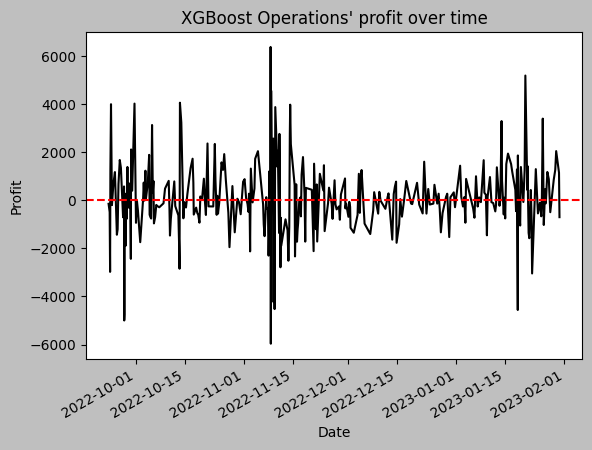

In [11]:
plot = df_ops[["close_time", "op_full_profit"]].set_index("close_time").sort_index(). \
                plot(title="XGBoost Operations' profit over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit"
                    )

plt.axhline(y=0.0, color='r', linestyle='--')

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_xgboost_ops_profit.png")

<AxesSubplot: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

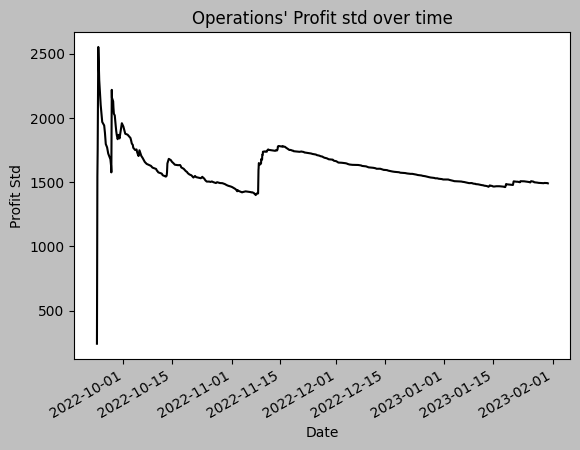

In [12]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<AxesSubplot: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

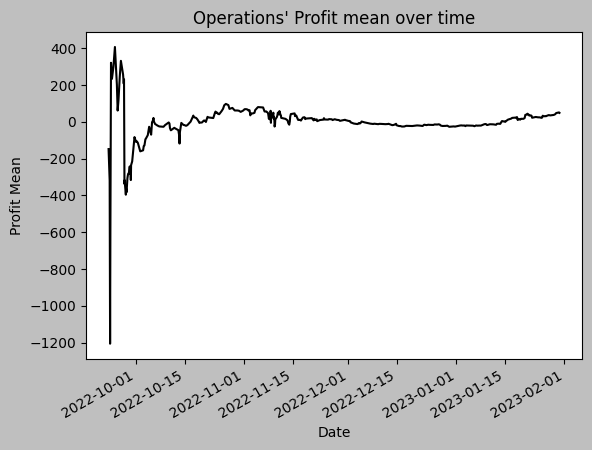

In [13]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

#### LSTM

In [14]:
df_ops = df_lstm_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

In [15]:
accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

In [16]:
df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

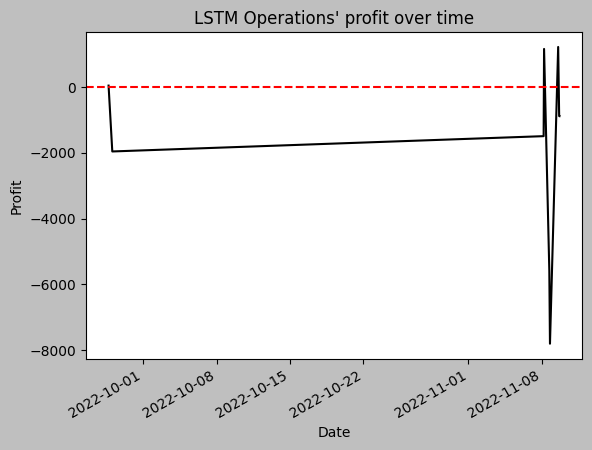

In [17]:
plot = df_ops[["close_time", "op_full_profit"]].set_index("close_time").sort_index(). \
                plot(title="LSTM Operations' profit over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit"
                    )

plt.axhline(y=0.0, color='r', linestyle='--')

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_lstm_ops_profit.png")

<AxesSubplot: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

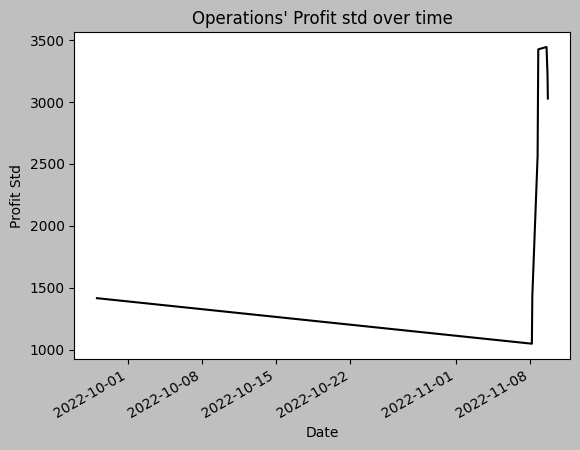

In [18]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<AxesSubplot: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

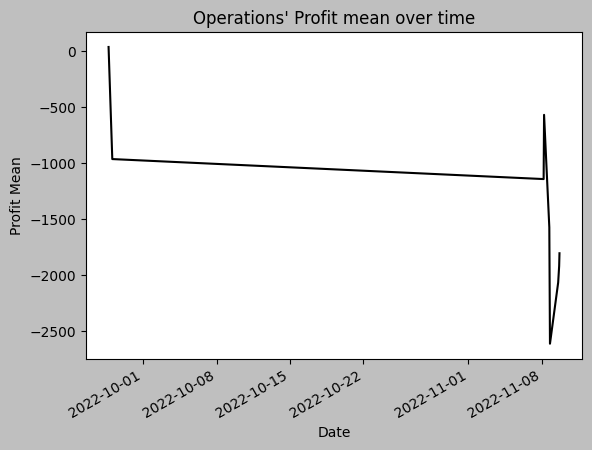

In [19]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

#### LogReg

In [20]:
df_ops = df_logreg_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

In [21]:
accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

In [22]:
df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

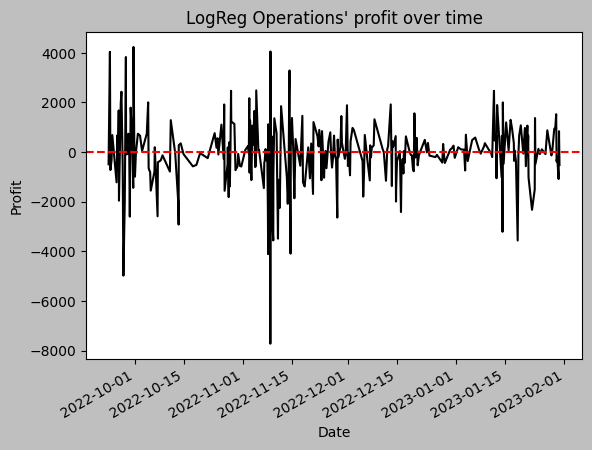

In [23]:
plot = df_ops[["close_time", "op_full_profit"]].set_index("close_time").sort_index(). \
                plot(title="LogReg Operations' profit over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit"
                    )

plt.axhline(y=0.0, color='r', linestyle='--')

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_logreg_ops_profit.png")

<AxesSubplot: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

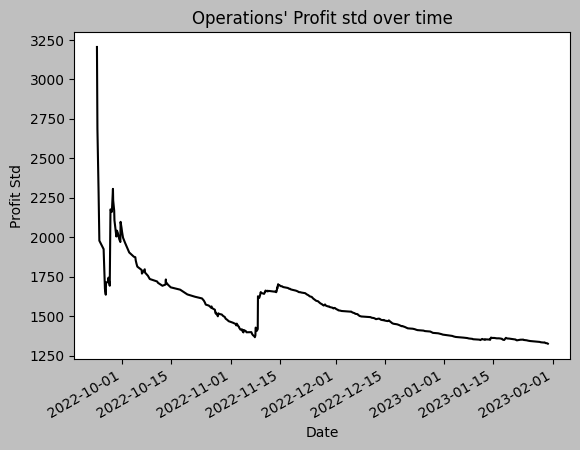

In [24]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<AxesSubplot: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

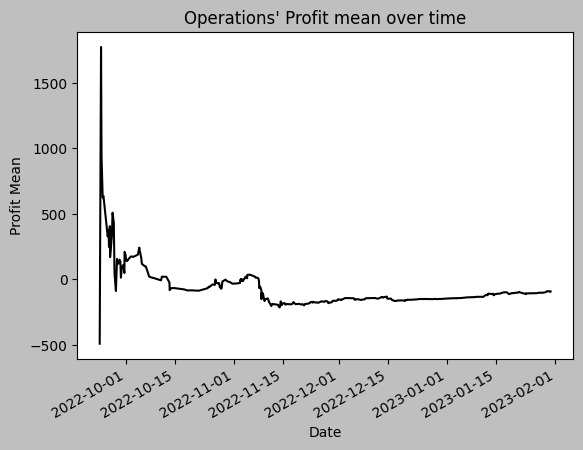

In [25]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

### QS plots

In [81]:
import quantstats as qs #import lib here otherwise it affects the design of the other plots

In [101]:
df_benchmark = df_benchmark_portf_pnl[["close_time", "pctchg_pos", "logret_pos"]] \
                .rename(columns={"close_time": "date"}) \
                .set_index("date").sort_index()

df_benchmark.loc[:, "logret_accum"] = df_benchmark["logret_pos"].cumsum()
df_benchmark.loc[:, "pctchg_accum"] = np.exp(df_benchmark["logret_accum"]) - 1

df_benchmark = df_benchmark[["pctchg_pos", "pctchg_accum"]].rename(columns={"pctchg_pos": "benchm_pctchg_pos",
                                                                           "pctchg_accum": "benchm_pctchg_accum"})

df_benchmark.index = pd.to_datetime(df_benchmark.index)

#### XGBoost

In [102]:
df_logret = df_xgb_portf_pnl[["close_time", "logret_pos"]]
df_logret.loc[:, "date"] = df_logret["close_time"].dt.date

In [103]:
df_logret_daily = df_logret.groupby("date")["logret_pos"].sum().reset_index().set_index("date").sort_index()

df_logret_daily.loc[:, "portf_logret_accum"] = df_logret_daily["logret_pos"].cumsum()

df_logret_daily.loc[:, "portf_pctchg_accum"] = np.exp(df_logret_daily["portf_logret_accum"]) - 1
df_logret_daily.loc[:, "portf_pctchg_pos"] = np.exp(df_logret_daily["logret_pos"]) - 1

df_pctchg_daily = df_logret_daily[["portf_pctchg_pos", "portf_pctchg_accum"]]

df_pctchg_daily.index = pd.to_datetime(df_pctchg_daily.index)

In [104]:
# full portfolio plot
df_pctchg_daily_portf = pd.DataFrame(df_pctchg_daily, index=df_pctchg_daily.index)
df_pctchg_daily_benchm = pd.DataFrame(df_benchmark, index=df_benchmark.index)

df = df_pctchg_daily_portf.merge(df_pctchg_daily_benchm, left_index=True, right_index=True, how="left")

In [105]:
df.loc[:, "benchm_pctchg_pos"] = df["benchm_pctchg_pos"].fillna(0)
df.loc[:, "benchm_pctchg_accum"] = df["benchm_pctchg_accum"].ffill()
df.head(10)

,portf_pctchg_pos,portf_pctchg_accum,benchm_pctchg_pos,benchm_pctchg_accum
date,,,,
2022-09-23,0.010669,0.010669,0.024135,0.024135
2022-09-24,0.010861,0.021646,0.000000,0.024135
2022-09-25,-0.012853,0.008514,0.000000,0.024135
2022-09-26,0.019962,0.028646,-0.008963,0.014956
2022-09-27,-0.067035,-0.040309,0.014489,0.029662
2022-09-28,-0.008929,-0.048878,-0.003902,0.025644
2022-09-29,0.004514,-0.044584,0.003755,0.029495
2022-09-30,0.021464,-0.024077,-0.009422,0.019795
2022-10-01,-0.003029,-0.027033,0.000000,0.019795


In [106]:
qs.reports.metrics(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, periods_per_year=360)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-09-23  2022-09-23
End Period          2023-01-30  2023-01-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      68.0%

Cumulative Return   10.18%      14.69%
CAGR﹪              31.57%      47.37%

Sharpe              1.22        0.96
Prob. Sharpe Ratio  76.01%      70.89%
Sortino             1.83        1.37
Sortino/√2          1.29        0.97
Omega               1.21        1.21

Max Drawdown        -10.11%     -31.07%
Longest DD Days     85          83

Gain/Pain Ratio     0.21        0.21
Gain/Pain (1M)      1.05        0.9

Payoff Ratio        1.52        0.82
Profit Factor       1.21        1.21
Common Sense Ratio  1.56        1.74
CPC Index           0.89        0.51
Tail Ratio          1.29        1.44
Outlier Win Ratio   6.55        4.93
Outlier Loss Ratio  8.62        3.02

MTD                 15.25%      35.14%
3M                  5.85%       3.08%

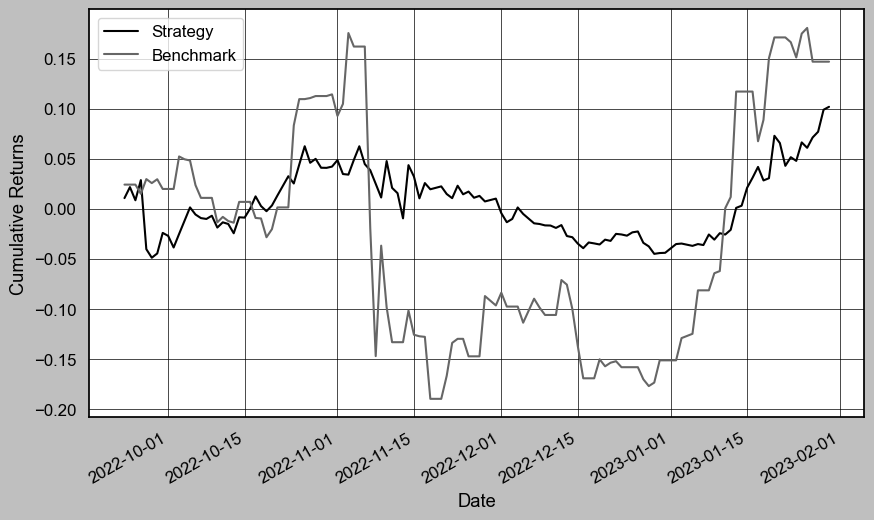

In [107]:
plt.style.use("grayscale")

plot = df[["portf_pctchg_accum", "benchm_pctchg_accum"]] \
            .rename(columns={"portf_pctchg_accum": "Strategy",
                            "benchm_pctchg_accum": "Benchmark"}) \
            .plot()

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_xgboost_portf_vs_benchmk_rets.png")

#### LSTM

In [108]:
df_logret = df_lstm_portf_pnl[["close_time", "logret_pos"]]
df_logret.loc[:, "date"] = df_logret["close_time"].dt.date

In [109]:
df_logret_daily = df_logret.groupby("date")["logret_pos"].sum().reset_index().set_index("date").sort_index()

df_logret_daily.loc[:, "portf_logret_accum"] = df_logret_daily["logret_pos"].cumsum()

df_logret_daily.loc[:, "portf_pctchg_accum"] = np.exp(df_logret_daily["portf_logret_accum"]) - 1
df_logret_daily.loc[:, "portf_pctchg_pos"] = np.exp(df_logret_daily["logret_pos"]) - 1

df_pctchg_daily = df_logret_daily[["portf_pctchg_pos", "portf_pctchg_accum"]]

df_pctchg_daily.index = pd.to_datetime(df_pctchg_daily.index)

In [110]:
# full portfolio plot
df_pctchg_daily_portf = pd.DataFrame(df_pctchg_daily, index=df_pctchg_daily.index)
df_pctchg_daily_benchm = pd.DataFrame(df_benchmark, index=df_benchmark.index)

df = df_pctchg_daily_portf.merge(df_pctchg_daily_benchm, left_index=True, right_index=True, how="left")

In [111]:
df.loc[:, "benchm_pctchg_pos"] = df["benchm_pctchg_pos"].fillna(0)
df.loc[:, "benchm_pctchg_accum"] = df["benchm_pctchg_accum"].ffill()
df.head(10)

,portf_pctchg_pos,portf_pctchg_accum,benchm_pctchg_pos,benchm_pctchg_accum
date,,,,
2022-09-27,0.000249,0.000249,0.014489,0.029662
2022-09-28,-0.013085,-0.012839,-0.003902,0.025644
2022-11-08,-0.092769,-0.104417,-0.130479,-0.147112
2022-11-09,-0.004224,-0.108199,0.129326,-0.036812


In [112]:
qs.reports.metrics(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, periods_per_year=360)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-09-27  2022-09-27
End Period          2022-11-09  2022-11-09
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   -10.82%     -0.77%
CAGR﹪              -62.17%     -6.34%

Sharpe              -11.87      0.42
Prob. Sharpe Ratio  0.0%        51.53%
Sortino             -11.11      0.69
Sortino/√2          -7.86       0.48
Omega               0.0         0.0

Max Drawdown        -10.84%     -13.39%
Longest DD Days     42          42

Gain/Pain Ratio     -1.0        0.07
Gain/Pain (1M)      -1.0        8.18

Payoff Ratio        0.0         0.22
Profit Factor       0.0         1.07
Common Sense Ratio  0.0         1.08
CPC Index           0.0         0.12
Tail Ratio          0.01        1.01
Outlier Win Ratio   252.89      0.88
Outlier Loss Ratio  2.96        1.62

MTD                 -9.66%      -1.8%
3M                  -10.82%     -0.77

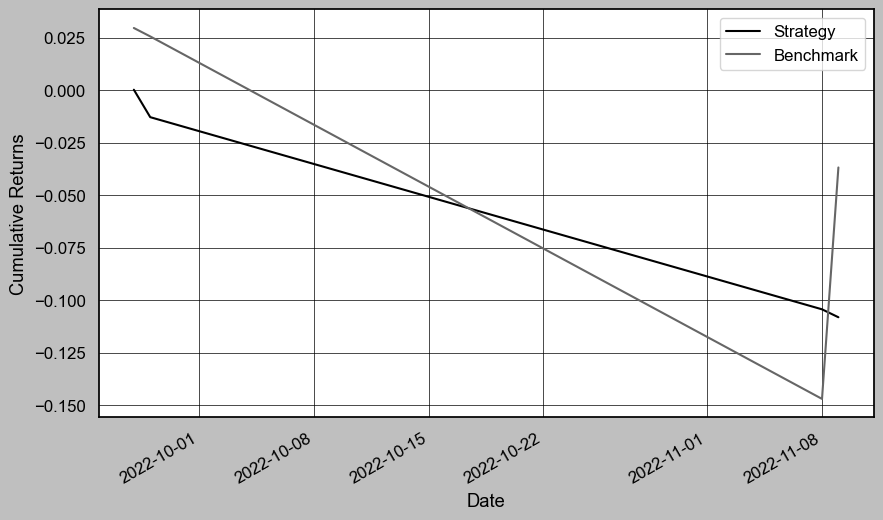

In [113]:
plt.style.use("grayscale")

plot = df[["portf_pctchg_accum", "benchm_pctchg_accum"]] \
            .rename(columns={"portf_pctchg_accum": "Strategy",
                            "benchm_pctchg_accum": "Benchmark"}) \
            .plot()

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_lstm_portf_vs_benchmk_rets.png")

#### LogReg

In [114]:
df_logret = df_logreg_portf_pnl[["close_time", "logret_pos"]]
df_logret.loc[:, "date"] = df_logret["close_time"].dt.date

In [115]:
df_logret_daily = df_logret.groupby("date")["logret_pos"].sum().reset_index().set_index("date").sort_index()

df_logret_daily.loc[:, "portf_logret_accum"] = df_logret_daily["logret_pos"].cumsum()

df_logret_daily.loc[:, "portf_pctchg_accum"] = np.exp(df_logret_daily["portf_logret_accum"]) - 1
df_logret_daily.loc[:, "portf_pctchg_pos"] = np.exp(df_logret_daily["logret_pos"]) - 1

df_pctchg_daily = df_logret_daily[["portf_pctchg_pos", "portf_pctchg_accum"]]

df_pctchg_daily.index = pd.to_datetime(df_pctchg_daily.index)

In [116]:
# full portfolio plot
df_pctchg_daily_portf = pd.DataFrame(df_pctchg_daily, index=df_pctchg_daily.index)
df_pctchg_daily_benchm = pd.DataFrame(df_benchmark, index=df_benchmark.index)

df = df_pctchg_daily_portf.merge(df_pctchg_daily_benchm, left_index=True, right_index=True, how="left")

In [117]:
df.loc[:, "benchm_pctchg_pos"] = df["benchm_pctchg_pos"].fillna(0)
df.loc[:, "benchm_pctchg_accum"] = df["benchm_pctchg_accum"].ffill()
df.head(10)

,portf_pctchg_pos,portf_pctchg_accum,benchm_pctchg_pos,benchm_pctchg_accum
date,,,,
2022-09-23,0.018846,0.018846,0.024135,0.024135
2022-09-24,0.002355,0.021245,0.000000,0.024135
2022-09-25,-0.003526,0.017644,0.000000,0.024135
2022-09-26,0.006765,0.024528,-0.008963,0.014956
2022-09-27,-0.019778,0.004265,0.014489,0.029662
2022-09-28,0.010839,0.015151,-0.003902,0.025644
2022-09-29,-0.001291,0.013840,0.003755,0.029495
2022-09-30,0.013137,0.027160,-0.009422,0.019795
2022-10-01,0.004639,0.031924,0.000000,0.019795


In [118]:
qs.reports.metrics(df["portf_pctchg_pos"], df["benchm_pctchg_pos"], grayscale=True, periods_per_year=360)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2022-09-23  2022-09-23
End Period          2023-01-30  2023-01-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      67.0%

Cumulative Return   -18.72%     4.51%
CAGR﹪              -44.37%     13.3%

Sharpe              -2.12       0.54
Prob. Sharpe Ratio  9.0%        61.71%
Sortino             -2.43       0.74
Sortino/√2          -1.72       0.52
Omega               0.71        0.71

Max Drawdown        -28.1%      -31.07%
Longest DD Days     117         87

Gain/Pain Ratio     -0.29       0.11
Gain/Pain (1M)      -0.68       0.5

Payoff Ratio        0.52        0.87
Profit Factor       0.71        1.11
Common Sense Ratio  0.57        1.46
CPC Index           0.19        0.47
Tail Ratio          0.8         1.31
Outlier Win Ratio   6.44        3.75
Outlier Loss Ratio  6.76        3.33

MTD                 6.48%       22.12%
3M                  -18.27%     -5.28%


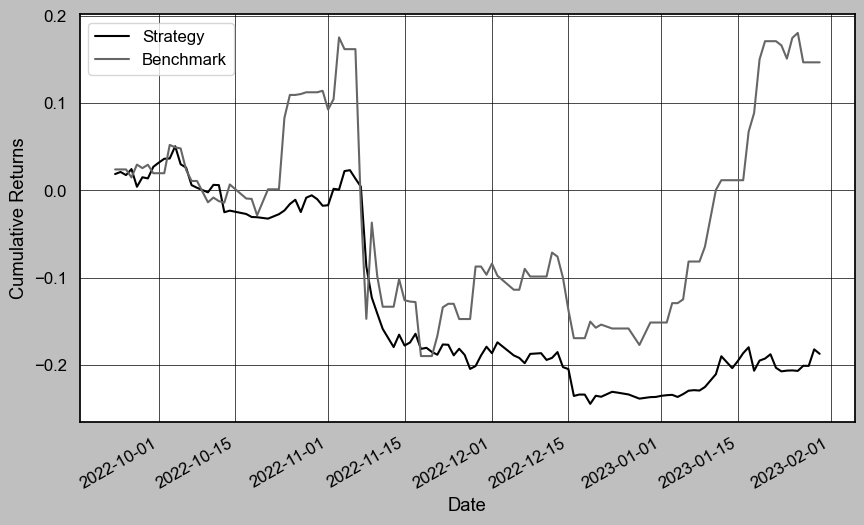

In [119]:
plt.style.use("grayscale")

plot = df[["portf_pctchg_accum", "benchm_pctchg_accum"]] \
            .rename(columns={"portf_pctchg_accum": "Strategy",
                            "benchm_pctchg_accum": "Benchmark"}) \
            .plot()

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_logreg_portf_vs_benchmk_rets.png")